# Уровень добычи золота

Есть данные технологического процесса добычи золота. Необходимо построить модель, которая должна предсказать коэффициент восстановления золота из золотосодержащей руды. В вашем распоряжении данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.


##### 1. Подготовка данных
* [1.1 Открытие данных и их изучение](#Part_1)
* [1.2 Проверка корректности заполнения rougher.output.recovery](#Part_1.2)
* [1.3 Анализ признаков в тестовой выборке](#Part_1.3)
* [1.4 Предобработка данных](#Part_1.4)

##### 2. Анализ данных
* [2.1 Концентрация металлов (Au, Ag, Pb) на различных этапах очистки](#Part_2)
* [2.2 Сравнение распределения размеров гранул сырья на обучающей и тестовой выборках](#Part_2.2)
* [2.3 Исследование суммарной концентрации всех веществ на разных стадиях](#Part_2.2)

##### 3. [Модель](#Part_3)

<a id='Part_1'></a>
# 1. Подготовка данных
## 1.1 Открытие данных и их изучение

In [1]:
import pandas as pd
import plotly.express as px
import numpy as np

import plotly.express as px
from scipy import stats as st
import plotly.io as pio
pio.renderers.default='notebook'

import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.ticker import PercentFormatter

from sklearn.model_selection import cross_val_score
from sklearn.metrics.scorer import make_scorer

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyClassifier
from sklearn.dummy import DummyRegressor

In [2]:
#загрузим датасеты
df_train = pd.read_csv('/datasets/gold_recovery_train.csv')
df_test = pd.read_csv('/datasets/gold_recovery_test.csv')
df_full = pd.read_csv('/datasets/gold_recovery_full.csv')

In [3]:
df_train.info()
print()
df_test.info()
print()
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
date                                                  16860 non-null object
final.output.concentrate_ag                           16788 non-null float64
final.output.concentrate_pb                           16788 non-null float64
final.output.concentrate_sol                          16490 non-null float64
final.output.concentrate_au                           16789 non-null float64
final.output.recovery                                 15339 non-null float64
final.output.tail_ag                                  16794 non-null float64
final.output.tail_pb                                  16677 non-null float64
final.output.tail_sol                                 16715 non-null float64
final.output.tail_au                                  16794 non-null float64
primary_cleaner.input.sulfate                         15553 non-null float64
primary_cleaner.input.depressant             

In [4]:
print('train :', df_train.shape, '\ntest :',df_test.shape,  '\nfull :',df_full.shape)

train : (16860, 87) 
test : (5856, 53) 
full : (22716, 87)


In [5]:
df_train.head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


### Промежуточный вывод
Трейн датасет составляет около 74% от общего. В тестовом отсутствует 34 столбец. Посмотрим перечень столбцов которые есть в трейне и перечень отсутствующих в тесте стобцов. В датасетах есть пропуски.

<a id='Part_1.2'></a>
## 1.2 Проверка корректности заполнения rougher.output.recovery
Посчитаем recovery для 'rougher.output.recovery'на обучающей выборке и проверим правильность заполнения столбца с помощью вычисления MAE.
Для этого сначала избавимся от пропусков

In [6]:
df_train = df_train.dropna(subset = ['rougher.output.recovery'])
df_train['rougher.output.recovery'].isnull().sum()

0

In [7]:
C = df_train['rougher.output.concentrate_au']
F = df_train['rougher.input.feed_au']
T = df_train['rougher.output.tail_au']
recovery = C * (F - T) / (F * (C - T)) * 100
mean_absolute_error(recovery, df_train['rougher.output.recovery'])

9.444891926100695e-15

### Промежуточный вывод
Мы получили МАЕ равное нулю, это означает, что указаные данные в столбце rougher.output.recovery указаны верно.

<a id='Part_1.3'></a>
## 1.3 Анализ признаков в тестовой выборке
Найдем признаки которые есть только в тестовой выборке.

In [8]:
train_cols = df_train.columns
train_cols

Index(['date', 'final.output.concentrate_ag', 'final.output.concentrate_pb',
       'final.output.concentrate_sol', 'final.output.concentrate_au',
       'final.output.recovery', 'final.output.tail_ag', 'final.output.tail_pb',
       'final.output.tail_sol', 'final.output.tail_au',
       'primary_cleaner.input.sulfate', 'primary_cleaner.input.depressant',
       'primary_cleaner.input.feed_size', 'primary_cleaner.input.xanthate',
       'primary_cleaner.output.concentrate_ag',
       'primary_cleaner.output.concentrate_pb',
       'primary_cleaner.output.concentrate_sol',
       'primary_cleaner.output.concentrate_au',
       'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_pb',
       'primary_cleaner.output.tail_sol', 'primary_cleaner.output.tail_au',
       'primary_cleaner.state.floatbank8_a_air',
       'primary_cleaner.state.floatbank8_a_level',
       'primary_cleaner.state.floatbank8_b_air',
       'primary_cleaner.state.floatbank8_b_level',
       'primary_clean

In [9]:
test_cols = df_test.columns

In [10]:
train_not_test = train_cols.difference(test_cols)
train_not_test

Index(['final.output.concentrate_ag', 'final.output.concentrate_au',
       'final.output.concentrate_pb', 'final.output.concentrate_sol',
       'final.output.recovery', 'final.output.tail_ag', 'final.output.tail_au',
       'final.output.tail_pb', 'final.output.tail_sol',
       'primary_cleaner.output.concentrate_ag',
       'primary_cleaner.output.concentrate_au',
       'primary_cleaner.output.concentrate_pb',
       'primary_cleaner.output.concentrate_sol',
       'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_au',
       'primary_cleaner.output.tail_pb', 'primary_cleaner.output.tail_sol',
       'rougher.calculation.au_pb_ratio',
       'rougher.calculation.floatbank10_sulfate_to_au_feed',
       'rougher.calculation.floatbank11_sulfate_to_au_feed',
       'rougher.calculation.sulfate_to_au_concentrate',
       'rougher.output.concentrate_ag', 'rougher.output.concentrate_au',
       'rougher.output.concentrate_pb', 'rougher.output.concentrate_sol',
       'roughe

### Промежуточный вывод
В тесте присутствуют только параметры входящих смесей и параметры проходящей операции, т.е. отсутствует выходные данные по результатам технологического этапа.

<a id='Part_1.4'></a>
## 1.4 Предобработка данных
Заполним пропуски в датасетах соседними значениями. Приведем столбец date к формату даты.

In [11]:
df_train = df_train.fillna(method='ffill')

In [12]:
df_test = df_test.fillna(method='ffill')

In [13]:
df_train['date'] = pd.to_datetime(df_train['date'], yearfirst=True)
df_test['date'] = pd.to_datetime(df_test['date'], yearfirst=True)
df_full['date'] = pd.to_datetime(df_full['date'], yearfirst=True)

Избавимся от нулей в выходных концентрациях и от нулей и 100% в рекавери.

In [14]:
for i in df_train.filter(regex='output.concentrate').columns:
    df_train = df_train.loc[(df_train[i] != 0) ]
    
for i in df_train.filter(regex='output.recovery').columns:
    df_train = df_train.loc[(df_train[i] != 0) & (df_train[i] != 100)]

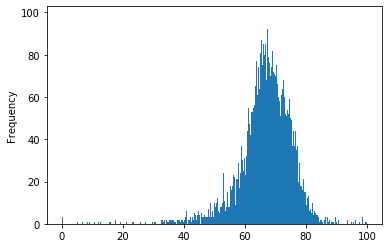

In [15]:
df_train['final.output.recovery'].plot.hist(bins=1000)

<a id='Part_2'></a>
# 2. Анализ данных
## 2.1 Концентрация металлов (Au, Ag, Pb) на различных этапах очистки

In [16]:
df_train.filter(regex='concentrate').columns

Index(['final.output.concentrate_ag', 'final.output.concentrate_pb',
       'final.output.concentrate_sol', 'final.output.concentrate_au',
       'primary_cleaner.output.concentrate_ag',
       'primary_cleaner.output.concentrate_pb',
       'primary_cleaner.output.concentrate_sol',
       'primary_cleaner.output.concentrate_au',
       'rougher.calculation.sulfate_to_au_concentrate',
       'rougher.output.concentrate_ag', 'rougher.output.concentrate_pb',
       'rougher.output.concentrate_sol', 'rougher.output.concentrate_au'],
      dtype='object')

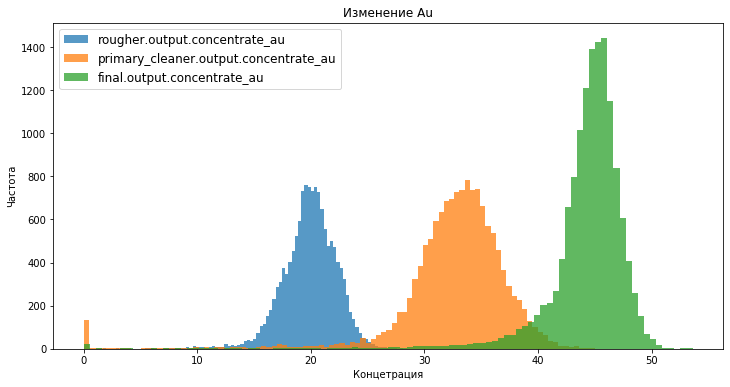

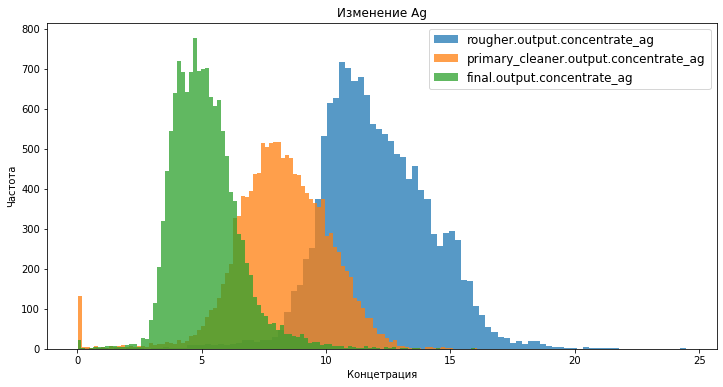

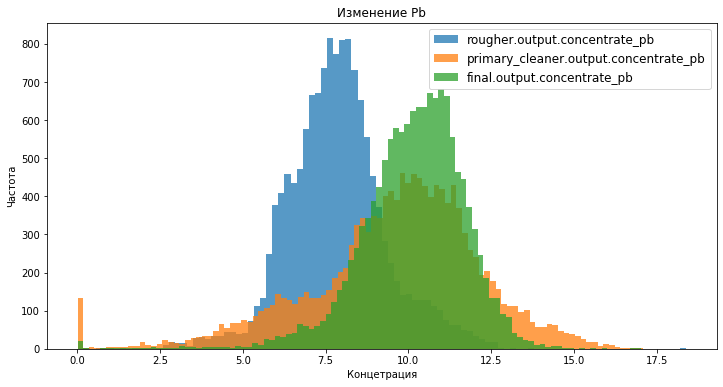

In [17]:
def plot_conc(df,set1,set2,set3,title):
    fig, axs = plt.subplots(figsize=(12,6))
    n_bins = 100
    axs.hist(df[set1],
            bins=n_bins, alpha=0.75,  
            label = df[set1].name)
    axs.hist(df[set2], 
            bins=n_bins, alpha=0.75, 
            label = df[set2].name)
    axs.hist(df[set3], 
            bins=n_bins, alpha=0.75, 
            label = df[set3].name)    
    axs.legend(prop={'size': 12})
    axs.set_title(title)
    axs.set_xlabel('Концетрация')
    axs.set_ylabel('Частота')
    
plot_conc(df_train,'rougher.output.concentrate_au',
          'primary_cleaner.output.concentrate_au',
          'final.output.concentrate_au',
          'Изменение Au')
plot_conc(df_train,'rougher.output.concentrate_ag',
          'primary_cleaner.output.concentrate_ag',
          'final.output.concentrate_ag',
          'Изменение Ag')
plot_conc(df_train,'rougher.output.concentrate_pb',
          'primary_cleaner.output.concentrate_pb',
          'final.output.concentrate_pb',
          'Изменение Pb')

### Промежуточный вывод
Как видно из гистограмм выше:
* концетрация золота с каждым этапом очистки значительно растет
* концетрация серебра с каждым этапом очистки значительно падает
* концетрация свинца после первого этапа очистки растет, но затем не изменяется.

<a id='Part_2.2'></a>
## 2.2 Сравнение распределения размеров гранул сырья на обучающей и тестовой выборках

In [18]:
df_train.filter(regex='size').columns

Index(['primary_cleaner.input.feed_size', 'rougher.input.feed_size'], dtype='object')

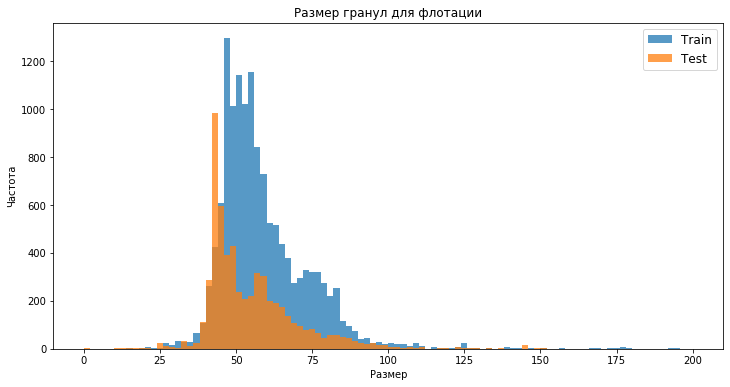

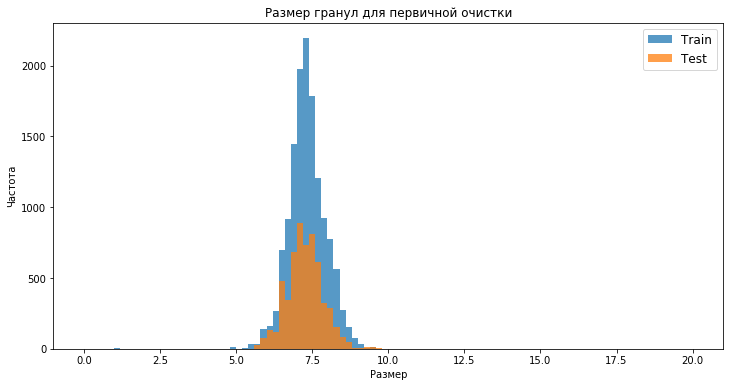

In [19]:
def plot_size(df, df2, range, set1,df_name, df_name2, title):
    fig, axs = plt.subplots(figsize=(12,6))
    n_bins = 100
    axs.hist(df[set1],
            bins=n_bins, alpha=0.75,  
            label = df_name, range=range)
    axs.hist(df2[set1], 
            bins=n_bins, alpha=0.75, 
            label = df_name2, range=range)
    axs.legend(prop={'size': 12})
    axs.set_title(title)
    axs.set_xlabel('Размер')
    axs.set_ylabel('Частота')
    
plot_size(df_train,df_test, (0, 200), 'rougher.input.feed_size','Train','Test','Размер гранул для флотации')
plot_size(df_train,df_test, (0, 20), 'primary_cleaner.input.feed_size','Train','Test','Размер гранул для первичной очистки')

In [20]:
df_train['rougher.input.feed_size'].mean()

60.27983848320857

In [21]:
df_train['rougher.input.feed_size'].median()

55.39246709524749

In [22]:
df_test['rougher.input.feed_size'].mean()

55.89886568885065

In [23]:
df_test['rougher.input.feed_size'].median()

49.96479572039952

### Промежуточный вывод
Как видно по гистограммам выше размер гранул отличается на 10%.

<a id='Part_2.3'></a>
## 2.3 Исследование суммарной концентрации всех веществ на разных стадиях

In [24]:
df_train.filter(regex='rougher.output').columns

Index(['rougher.output.concentrate_ag', 'rougher.output.concentrate_pb',
       'rougher.output.concentrate_sol', 'rougher.output.concentrate_au',
       'rougher.output.recovery', 'rougher.output.tail_ag',
       'rougher.output.tail_pb', 'rougher.output.tail_sol',
       'rougher.output.tail_au'],
      dtype='object')

In [25]:
df_concetrate = df_train[['rougher.input.feed_ag', 'rougher.input.feed_pb',
       'rougher.input.feed_sol', 'rougher.input.feed_au']].median()
df_rougth_out = df_train[df_train.filter(regex='rougher.output.concentrate').columns].median()
df_primary_out = df_train[df_train.filter(regex='primary_cleaner.output.concentrate').columns].median()
df_final = df_train[df_train.filter(regex='final.output.concentrate').columns].median()

In [26]:
df_concetrate.index = ['ag', 'pb','sol','au']
df_rougth_out.index = ['ag', 'pb','sol','au']
df_primary_out.index = ['ag', 'pb','sol','au']
df_final.index = ['ag', 'pb','sol','au']

df_sum = df_concetrate.to_frame(name='input_feed')
df_sum['rougth'] = df_rougth_out.to_frame(name='rougth')
df_sum['primary'] = df_primary_out.to_frame(name='primary')
df_sum['final'] = df_final.to_frame(name='final')

In [27]:
df_sum.T

,ag,pb,sol,au
input_feed,8.147594,3.400117,36.980572,7.630314
rougth,11.817171,7.788460,29.331280,20.006640
primary,8.233986,9.906577,9.648590,33.204518
final,4.997647,10.302015,8.811908,44.869295


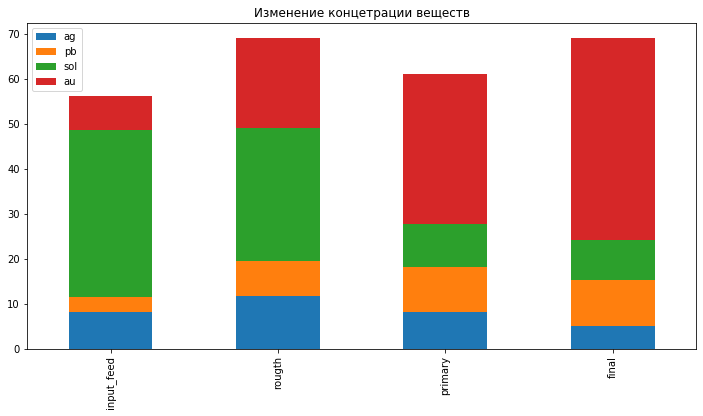

In [28]:
df_sum.T.plot(kind='bar', stacked=True,figsize=(12,6), title='Изменение концетрации веществ')

### Промежуточный вывод
Как видим из гистораграммы выше концетрация золота от этапа к этапу растет, причем уровень концентрации свинца в финальной стадии оказывается выше чем начальной.

<a id='Part_3'></a>
# 3. Модель
Зададим функцию расчета sMAPE.

In [29]:
def smape(predict, target):
    total = 0
    predict = pd.Series(predict)
    target = target.reset_index(drop=True)
    for i in range(len(predict)):
        total += (abs(target[i] - predict[i])) / ((abs(target[i]) + abs(predict[i])) / 2)
    result = total / len(predict) * 100
    return result

Выделим целевой признак для флотации и финальной стадии.

In [30]:
df_train = df_train.reset_index(drop=True)

In [31]:
rougher_train_target = df_train['rougher.output.recovery']
final_train_target = df_train['final.output.recovery']

Выделим для обучения модели признаки фазы флотации и финальной стадии. Удалим из обучающей выборки признаки которых нет в тестовой, это нужно чтобы в дальнейшем не произошел лик при обучении модели.

In [32]:
final_select_train_features = df_train[df_test.columns].drop(['date'], axis=1)

In [33]:
rougher_select_train_features = final_select_train_features[final_select_train_features.filter(regex='rougher').columns]

Найдем для тестовой выборки целевые признаки и затем сформируем target и features для тестовой выборки

In [34]:
rougher_itest = df_test.set_index('date')
final_itest = df_test.set_index('date')
ifull = df_full.set_index('date')

In [35]:
rougher_itest['rougher.output.recovery'] = ifull['rougher.output.recovery']
final_itest['final.output.recovery'] = ifull['final.output.recovery']

In [36]:
rougher_itest = rougher_itest.reset_index()
final_itest = final_itest.reset_index()

In [37]:
rougher_itest = rougher_itest.loc[(rougher_itest['rougher.output.recovery'] != 0) & (rougher_itest['rougher.output.recovery'] != 100)]
final_itest = final_itest.loc[(final_itest['final.output.recovery'] != 0) & (final_itest['final.output.recovery'] != 100)]

In [38]:
rougher_itest = rougher_itest.dropna(subset = ['rougher.output.recovery'])
final_itest = final_itest.dropna(subset = ['final.output.recovery'])

In [39]:
rougher_itest = rougher_itest[rougher_itest['rougher.output.recovery'] != 0]
final_itest = final_itest[final_itest['final.output.recovery'] != 0]

In [40]:
rougher_itest_features = rougher_itest[rougher_select_train_features.columns]
rougher_itest_target = rougher_itest['rougher.output.recovery']
final_itest_features = final_itest[final_select_train_features.columns]
final_itest_target = final_itest['final.output.recovery']

Применим скейлер к данным.

In [41]:
scaler = StandardScaler()

rougher_select_train_features = scaler.fit_transform(rougher_select_train_features)
rougher_itest_features = scaler.transform(rougher_itest_features)

final_select_train_features = scaler.fit_transform(final_select_train_features)
final_itest_features = scaler.fit_transform(final_itest_features)


Разобьем обучающую выборку на еще одну обучающую и валидационную и обучим модели для стадии флотации.

In [42]:
def metrics(target_valid,predicted_valid):# вывод метрик
    rmse = mean_squared_error(target_valid, predicted_valid) ** 0.5
    mean = predicted_valid.mean()
    r2 = r2_score(target_valid, predicted_valid)
    mae = mean_absolute_error(target_valid, predicted_valid)
    smape_ = smape(predicted_valid, target_valid)
    print("rMSE = {:.3f} | mean = {:.3f} | r2 = {:.3f} | mae = {:.3f} | sMAPE = {:.3f} %".format(
        rmse, mean, r2, mae, smape_))

In [43]:
features_train, features_valid, target_train, target_valid = train_test_split(
    rougher_select_train_features, rougher_train_target, test_size=0.25, random_state=123456)

model = LinearRegression().fit(features_train, target_train)

predict_valid = model.predict(features_valid)

metrics(target_valid, predict_valid)

rMSE = 6.290 | mean = 84.394 | r2 = 0.458 | mae = 4.329 | sMAPE = 5.429 %


In [44]:
model = DecisionTreeRegressor(random_state=123456)
parametrs = {'max_depth': range(1, 15)}
grid = GridSearchCV(model, parametrs, scoring = 'r2')
grid.fit(features_train, target_train)
grid.best_params_

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.



{'max_depth': 8}

In [45]:
model = DecisionTreeRegressor(max_depth=8, random_state=123456)
model.fit(features_train, target_train)
predict_valid = model.predict(features_valid)
metrics(target_valid, predict_valid)

rMSE = 5.787 | mean = 84.476 | r2 = 0.541 | mae = 3.440 | sMAPE = 4.401 %


In [46]:
model = RandomForestRegressor(random_state=123456)
parametrs = { 'n_estimators': range(10, 50, 10),'max_depth': range(10, 15)}
grid = GridSearchCV(model, parametrs, scoring = 'r2')
grid.fit(features_train, target_train)
grid.best_params_

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.



{'max_depth': 14, 'n_estimators': 40}

In [47]:
model = RandomForestRegressor(n_estimators=40, max_depth=14, random_state=123456).fit(features_train, target_train)
predict_valid = model.predict(features_valid)

metrics(target_valid, predict_valid)

rMSE = 4.440 | mean = 84.507 | r2 = 0.730 | mae = 2.424 | sMAPE = 3.166 %


Повторим туже процедуру для финальной стадии.

In [48]:
features_train, features_valid, target_train, target_valid = train_test_split(
    final_select_train_features, final_train_target, test_size=0.25, random_state=123456)

model = LinearRegression().fit(features_train, target_train)

predict_valid = model.predict(features_valid)

metrics(target_valid, predict_valid)

rMSE = 7.346 | mean = 66.618 | r2 = 0.344 | mae = 5.092 | sMAPE = 8.125 %


In [49]:
model = DecisionTreeRegressor(random_state=123456)
parametrs = {'max_depth': range(1, 15)}
grid = GridSearchCV(model, parametrs, scoring = 'r2')
grid.fit(features_train, target_train)
grid.best_params_

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.



{'max_depth': 6}

In [50]:
model = DecisionTreeRegressor(max_depth=6, random_state=123456).fit(features_train, target_train)
predict_valid = model.predict(features_valid)
metrics(target_valid, predict_valid)

rMSE = 7.118 | mean = 66.593 | r2 = 0.384 | mae = 4.807 | sMAPE = 7.773 %


In [51]:
model = RandomForestRegressor(random_state=123456)
parametrs = { 'n_estimators': range(10, 50, 10),'max_depth': range(10, 15)}
grid = GridSearchCV(model, parametrs, scoring = 'r2')
grid.fit(features_train, target_train)
grid.best_params_

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.



{'max_depth': 14, 'n_estimators': 40}

In [52]:
model = RandomForestRegressor(n_estimators=40, max_depth=14, random_state=123456).fit(features_train, target_train)
predict_valid = model.predict(features_valid)

metrics(target_valid, predict_valid)

rMSE = 5.735 | mean = 66.690 | r2 = 0.600 | mae = 3.664 | sMAPE = 5.960 %


Лучшей моделью по минимальному sMAPE на обоих стадиях стала RandomForestRegressor с параметрами n_estimators=40, max_depth=14.
Проверим модели с полученными гиперпараметрами на тестовой выборке и рассчитаем итоговый sMAPE.

In [53]:
model = RandomForestRegressor(n_estimators=40, max_depth=14, random_state=123456).fit(rougher_select_train_features, rougher_train_target)
rougher_predict_valid = model.predict(rougher_itest_features)

metrics(rougher_itest_target, rougher_predict_valid)
rougher_smape = smape(rougher_predict_valid, rougher_itest_target)

rMSE = 5.225 | mean = 85.850 | r2 = 0.304 | mae = 3.712 | sMAPE = 4.512 %


In [54]:
pd.Series(rougher_predict_valid).median()

85.43694650877059

In [55]:
model = RandomForestRegressor(n_estimators=40, max_depth=14, random_state=123456).fit(final_select_train_features, final_train_target)
final_predict_valid = model.predict(final_itest_features)

metrics(final_itest_target, final_predict_valid)
final_smape = smape(final_predict_valid, final_itest_target)

rMSE = 8.160 | mean = 66.110 | r2 = -0.218 | mae = 6.093 | sMAPE = 9.315 %


In [56]:
pd.Series(final_predict_valid).median()

66.77647211668719

In [57]:
sumSMAPE = rougher_smape * .25 + final_smape * .75
print("Итоговый sMAPE: {:.3f} %".format(sumSMAPE))

Итоговый sMAPE: 8.114 %


Мы получили довольно низкое значение sMAPE, теперь применим кросс-валидацию к обеим стадиям чтоб проверить качество модели

In [58]:
def smape_scor(y_true,y_pred):
    smape_scor = smape(y_pred,y_true)
    return smape_scor
my_scorer = make_scorer(smape_scor, greater_is_better=True)

model = RandomForestRegressor(n_estimators=40, max_depth=14, random_state=123456)
scores = cross_val_score(model, rougher_select_train_features, rougher_train_target, cv=10, scoring=my_scorer)
rougher_score = sum(scores) / len(scores)

scores = cross_val_score(model, final_select_train_features, final_train_target, cv=10, scoring=my_scorer)
final_score = sum(scores) / len(scores)
print("Rougher sMAPE = {:.3} %".format(rougher_score))
print("Final sMAPE = {:.3} %".format(final_score))

Rougher sMAPE = 6.87 %
Final sMAPE = 9.39 %


In [59]:
def smape_scor(y_true,y_pred):
    smape_scor = smape(y_pred,y_true)
    return smape_scor
my_scorer = make_scorer(smape_scor, greater_is_better=True)

model = RandomForestRegressor(n_estimators=40, max_depth=14, random_state=123456)
scores = cross_val_score(model, rougher_itest_features, rougher_itest_target, cv=10, scoring=my_scorer)
rougher_score = sum(scores) / len(scores)

scores = cross_val_score(model, final_itest_features, final_itest_target, cv=10, scoring=my_scorer)
final_score = sum(scores) / len(scores)
print("Rougher sMAPE = {:.3} %".format(rougher_score))
print("Final sMAPE = {:.3} %".format(final_score))

Rougher sMAPE = 4.19 %
Final sMAPE = 8.16 %


In [60]:
sumSMAPE_cross_val = rougher_score * .25 + final_score * .75
print("Итоговый sMAPE: {:.3f} %".format(sumSMAPE_cross_val))

Итоговый sMAPE: 7.170 %


Полученные значения качества модели на кросс-валидации значительно не отличаются от посчитанных прямым путем.

Проверим модель на адекватность.

In [61]:
dummy_reg = DummyRegressor(strategy ='median')
dummy_reg.fit(rougher_select_train_features, rougher_train_target)
dummy_reg_predict = dummy_reg.predict(rougher_itest_features)
metrics(rougher_itest_target, dummy_reg_predict)
dummy_rougher_smape = smape(dummy_reg_predict, rougher_itest_target)

rMSE = 6.350 | mean = 85.492 | r2 = -0.028 | mae = 4.186 | sMAPE = 5.042 %


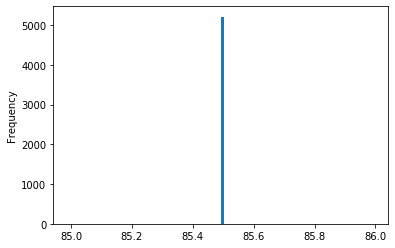

In [62]:
pd.Series(dummy_reg_predict).plot.hist(bins=100)

In [63]:
pd.Series(dummy_reg_predict).median()

85.49168481255937

In [64]:
dummy_reg.fit(final_select_train_features, final_train_target)
dummy_reg_predict = dummy_reg.predict(final_itest_features)
metrics(final_itest_target, dummy_reg_predict)
dummy_final_smape = smape(dummy_reg_predict, final_itest_target)

rMSE = 7.516 | mean = 67.424 | r2 = -0.034 | mae = 5.565 | sMAPE = 8.354 %


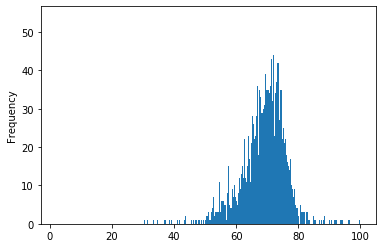

In [65]:
final_itest_target.plot.hist(bins=1000)

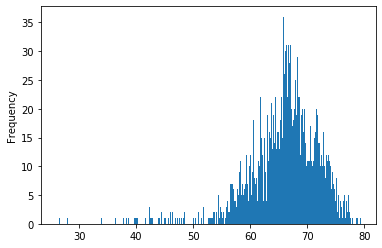

In [66]:
pd.Series(final_predict_valid).plot.hist(bins=1000)

In [67]:
rougher_itest_target.median()

87.44942652350832

In [68]:
pd.Series(dummy_reg_predict).median()

67.42447578699218

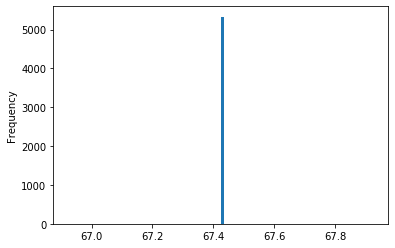

In [69]:
pd.Series(dummy_reg_predict).plot.hist(bins=100)

In [70]:
dummy_sumSMAPE = dummy_rougher_smape * .25 + dummy_final_smape * .75
print("Итоговый dummy sMAPE: {:.3f} %".format(sumSMAPE))

Итоговый dummy sMAPE: 8.114 %


In [71]:
if sumSMAPE_cross_val < dummy_sumSMAPE:
    print("Модель адекватна")   
else:
    print("Модель неадекватна")

Модель адекватна


## Вывод
В этой работе мы разработали модель предсказания эффективности обогащения чернового концентрата rougher.output.recovery и 
эффективности обогащения финального концентрата. Используя метрику оценки качества sMAPE на кросс-валидации, модель показала, что она может предсказывать данные параметры с ошибкой в __7.17%__, что меньше чем константная модель (~8.114%). __Мы рекомендуем использовать данную модель для оценки эффективности обогащения.__